In [1]:
# Import Libraries
import torch
import clip
from PIL import Image
import os
import cv2
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import collections
from torch.utils.data import Dataset, DataLoader

In [2]:
UCF101_VID_PATH = "UCF-101"

UCF101_SPLIT_PATH = "UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist"

print(f"Video path: {UCF101_VID_PATH}")
print(f"Split path: {UCF101_SPLIT_PATH}")

Video path: UCF-101
Split path: UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
def parse_class_index(split_path, num_classes_to_take=15):
    """
    Parses classInd.txt to get a list of class names and a name-to-index map,
    but only takes the first `num_classes_to_take`.
    """
    class_ind_path = os.path.join(split_path, 'classInd.txt')
    class_list = []
    
    with open(class_ind_path, 'r') as f:
        for line in f:
            # Stop reading the file once we have enough classes
            if len(class_list) >= num_classes_to_take:
                break
            
            parts = line.strip().split()
            if len(parts) == 2:
                class_list.append(parts[1])
    
    # Sort the selected subset for consistency
    class_list.sort()
    # Create a mapping from class name to a 0-based index
    name_to_idx = {name: i for i, name in enumerate(class_list)}
    
    return class_list, name_to_idx

In [5]:
CLASSES, name_to_idx = parse_class_index(UCF101_SPLIT_PATH)
print(f"Successfully loaded {len(CLASSES)} classes.")
print("First 15 classes:", CLASSES)
print("Example name-to-index map:", {k: name_to_idx[k] for k in list(name_to_idx)})

Successfully loaded 15 classes.
First 15 classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats']
Example name-to-index map: {'ApplyEyeMakeup': 0, 'ApplyLipstick': 1, 'Archery': 2, 'BabyCrawling': 3, 'BalanceBeam': 4, 'BandMarching': 5, 'BaseballPitch': 6, 'Basketball': 7, 'BasketballDunk': 8, 'BenchPress': 9, 'Biking': 10, 'Billiards': 11, 'BlowDryHair': 12, 'BlowingCandles': 13, 'BodyWeightSquats': 14}


In [6]:
NUM_FRAMES_TO_SAMPLE = 8  # Number of frames to sample from each video
MODEL_NAME = "ViT-B/32"

In [7]:
def parse_train_split(split_path, video_root, name_to_idx_map, file_name):
    """Parses a trainlistXX.txt file, filtering for classes in name_to_idx_map."""
    train_file_path = os.path.join(split_path, file_name)
    video_paths = []
    labels = []
    
    with open(train_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                class_name = parts[0].split('/')[0]
                
                # --- KEY CHANGE ---
                # Only process the line if its class is in our selected subset of 15.
                if class_name in name_to_idx_map:
                    video_path = os.path.join(video_root, parts[0])
                    label = name_to_idx_map[class_name]
                    
                    video_paths.append(video_path)
                    labels.append(label)
                    
    return video_paths, labels

In [8]:
train_videos, train_labels = parse_train_split(UCF101_SPLIT_PATH, UCF101_VID_PATH, name_to_idx, 'trainlist01.txt')
print(f"Found {len(train_videos)} videos for training.")
print("\n--- Example Training Data ---")
for i in range(3):
    print(f"Video: {train_videos[i]}, Label: {train_labels[i]}")

Found 1442 videos for training.

--- Example Training Data ---
Video: UCF-101\ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi, Label: 0
Video: UCF-101\ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi, Label: 0
Video: UCF-101\ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi, Label: 0


In [9]:
def parse_test_split(split_path, video_root, name_to_idx_map,filename):
    """Parses a testlistXX.txt file, filtering for classes in name_to_idx_map."""
    test_file_path = os.path.join(split_path, filename)
    video_paths = []
    labels = []
    
    with open(test_file_path, 'r') as f:
        for line in f:
            # line is just "ClassName/video_name.avi"
            video_rel_path = line.strip()
            if not video_rel_path: continue # Skip empty lines

            class_name = video_rel_path.split('/')[0]
            
            # Only process if the class is in our selected subset
            if class_name in name_to_idx_map:
                video_path = os.path.join(video_root, video_rel_path)
                label = name_to_idx_map[class_name]
                
                video_paths.append(video_path)
                labels.append(label)
                
    return video_paths, labels

In [10]:
test_videos, test_labels = parse_test_split(UCF101_SPLIT_PATH, UCF101_VID_PATH, name_to_idx, 'testlist01.txt')
print(f"Found {len(test_videos)} videos for testing.")
print("\n--- Example testing Data ---")
for i in range(3):
    print(f"Video: {test_videos[i]}, Label: {test_labels[i]}")

Found 568 videos for testing.

--- Example testing Data ---
Video: UCF-101\ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi, Label: 0
Video: UCF-101\ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi, Label: 0
Video: UCF-101\ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi, Label: 0


In [11]:
CLIP_DURATION_SEC = 3  # How long the clip should be
NUM_FRAMES_IN_CLIP = 8 # How many frames to sample from that clip
FRAME_OUTPUT_PATH = "ExtractedFrames" 

In [12]:
try:
    model, preprocess = clip.load(MODEL_NAME, device=DEVICE)
    model.eval()
    print(f"CLIP model '{MODEL_NAME}' loaded successfully on {DEVICE}.")
except Exception as e:
    print(f"Error loading CLIP model: {e}")

CLIP model 'ViT-B/32' loaded successfully on cuda.


In [13]:
def extract_clip(video_path, clip_duration_sec, num_frames_in_clip, save_dir=None):
    """
    Extracts a clip from the video's center and optionally saves frames.
    """
    try:
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames_in_duration = int(clip_duration_sec * fps)
        
        if total_frames <= frames_in_duration:
            start_frame = 0
            clip_frame_count = total_frames
        else:
            center_frame = total_frames // 2
            start_frame = max(0, center_frame - (frames_in_duration // 2))
            clip_frame_count = frames_in_duration

        frame_indices = np.linspace(start_frame, start_frame + clip_frame_count - 1, num_frames_in_clip, dtype=int)
        
        frames = []
        for i, index in enumerate(frame_indices):
            cap.set(cv2.CAP_PROP_POS_FRAMES, index)
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_pil = Image.fromarray(frame_rgb)
                frames.append(frame_pil)
                if save_dir:
                    save_path = os.path.join(save_dir, f"frame_{i:02d}.jpg")
                    frame_pil.save(save_path)
        cap.release()
        return frames
    
    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
        return []

# Modeling

Model yang digunakan CLIP
https://github.com/openai/CLIP

In [14]:
def get_video_paths_and_labels(root_path, class_list):
    """Gathers video file paths and their corresponding labels for the selected classes."""
    video_paths = []
    labels = []
    label_to_idx = {name: i for i, name in enumerate(class_list)}

    if not os.path.exists(root_path):
        print(f"Error: Dataset path '{root_path}' not found.")
        print("Please update the UCF101_PATH variable in the Configuration cell.")
        return None, None

    for class_name in class_list:
        class_path = os.path.join(root_path, class_name)
        if os.path.isdir(class_path):
            for video_file in os.listdir(class_path):
                if video_file.endswith('.avi'):
                    video_paths.append(os.path.join(class_path, video_file))
                    labels.append(label_to_idx[class_name])
    
    print(f"Found {len(video_paths)} videos for {len(class_list)} classes.")
    return video_paths, labels

def sample_frames(video_path, num_frames):
    """Uniformly samples a given number of frames from a video."""
    try:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames == 0:
            print(f"Warning: Could not read frames from {video_path}")
            return []

        # Generate evenly spaced frame indices
        indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        
        frames = []
        for i in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                # Convert frame from BGR (OpenCV) to RGB (PIL)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(Image.fromarray(frame_rgb))
        cap.release()
        return frames
    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
        return []

def perform_zero_shot_classification(model, video_paths, true_labels, class_names, split_name):
    """
    Runs classification and saves frames into a split-specific folder.
    """
    text_prompts = [f"a photo of a person {c}" for c in class_names]
    text_inputs = torch.cat([clip.tokenize(prompt) for prompt in text_prompts]).to(DEVICE)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    predictions, ground_truth = [], []
    
    for i, video_path in enumerate(tqdm(video_paths, desc=f"Processing {split_name} Set")):
        
        # --- KEY FIX: Standardize the path separators ---
        video_path = video_path.replace("\\", "/")

        class_name = class_names[true_labels[i]]
        video_filename = os.path.splitext(os.path.basename(video_path))[0]
        save_directory = os.path.join(FRAME_OUTPUT_PATH, split_name, class_name, video_filename)
        
        frames = extract_clip(video_path, CLIP_DURATION_SEC, NUM_FRAMES_IN_CLIP, save_dir=save_directory)
        
        if not frames: continue
            
        image_inputs = torch.stack([preprocess(frame) for frame in frames]).to(DEVICE)
        
        with torch.no_grad():
            image_features = model.encode_image(image_inputs)
            video_feature = image_features.mean(dim=0)
            video_feature /= video_feature.norm(dim=-1, keepdim=True)
            
        logit_scale = model.logit_scale.exp()
        similarity = (logit_scale * video_feature @ text_features.T).softmax(dim=-1)
        _, top_pred_idx = similarity.topk(1)
        
        predictions.append(top_pred_idx.item())
        ground_truth.append(true_labels[i])
        
    return predictions, ground_truth

In [15]:
# Get the data paths and labels
video_files, video_labels = get_video_paths_and_labels(UCF101_VID_PATH, CLASSES)

Found 2010 videos for 15 classes.


In [16]:
import pandas as pd
def calculate_class_accuracy(true_labels, predicted_labels, class_names):
    """
    Calculates the accuracy for each class and returns a pandas DataFrame.

    Args:
        true_labels (list): The ground truth labels.
        predicted_labels (list): The labels predicted by the model.
        class_names (list): A list of all class names, ordered by their index.

    Returns:
        pandas.DataFrame: A DataFrame with 'Class' and 'Accuracy' columns,
                          sorted by accuracy in descending order.
    """
    # Generate the confusion matrix
    # The labels argument ensures the matrix is ordered correctly
    cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(len(class_names)))

    # Calculate per-class accuracy
    # cm.diagonal() gives the number of correct predictions (the diagonal elements)
    # cm.sum(axis=1) gives the total number of true samples for each class (sum of each row)
    # We add a small epsilon to the denominator to avoid division by zero if a class has no samples
    class_acc = cm.diagonal() / (cm.sum(axis=1) + 1e-15)

    # Create a DataFrame for easy viewing
    acc_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': class_acc
    })

    # Sort by accuracy to easily see the best and worst performing classes
    acc_df = acc_df.sort_values(by='Accuracy', ascending=False)
    
    # Reset index for clean presentation
    acc_df = acc_df.reset_index(drop=True)

    return acc_df

In [17]:
train_predicted_labels, train_true_labels = perform_zero_shot_classification(
    model,
    train_videos,
    train_labels,
    CLASSES,
    split_name='Train'
)

Processing Train Set: 100%|██████████| 1442/1442 [03:44<00:00,  6.43it/s]


In [18]:
train_class_accuracy= calculate_class_accuracy(train_true_labels, train_predicted_labels, CLASSES)
train_class_accuracy

,Class,Accuracy
0,BaseballPitch,1.000000
1,BandMarching,1.000000
2,BabyCrawling,1.000000
3,Billiards,1.000000
4,BlowingCandles,1.000000
5,BenchPress,1.000000
6,Biking,1.000000
7,BasketballDunk,0.968085
8,BlowDryHair,0.967742
9,BalanceBeam,0.922078


Top-1 Accuracy: 90.71%


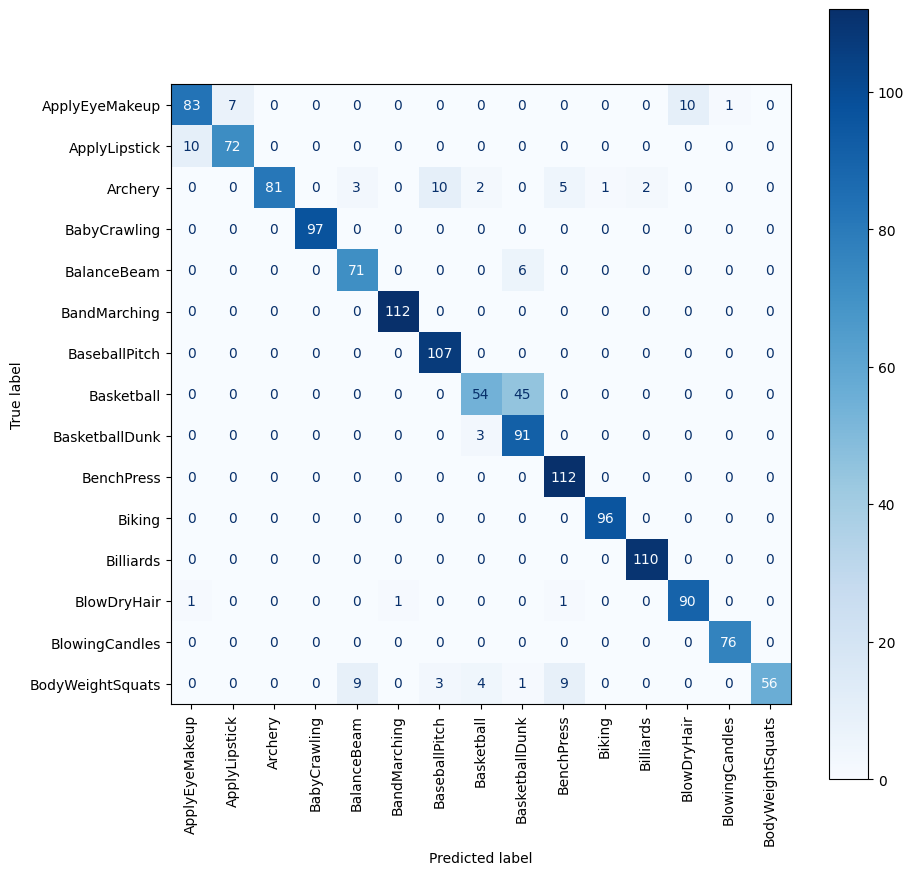

In [19]:
# 1. Calculate Top-1 Accuracy
top1_acc = accuracy_score(train_true_labels, train_predicted_labels)
print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")

# 2. Generate and Display Confusion Matrix
cm = confusion_matrix(train_true_labels, train_predicted_labels, labels=np.arange(len(CLASSES)))
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.show()

In [20]:
test_predicted_labels, test_true_labels = perform_zero_shot_classification(
    model,
    test_videos,
    test_labels,
    CLASSES,
    split_name='Test'
)

Processing Test Set: 100%|██████████| 568/568 [01:10<00:00,  8.00it/s]


In [21]:
test_class_accuracy = calculate_class_accuracy(test_true_labels, test_predicted_labels, CLASSES)
test_class_accuracy

,Class,Accuracy
0,ApplyEyeMakeup,1.000000
1,Archery,1.000000
2,BabyCrawling,1.000000
3,BandMarching,1.000000
4,BlowingCandles,1.000000
5,BenchPress,1.000000
6,Biking,1.000000
7,Billiards,1.000000
8,BlowDryHair,0.973684
9,ApplyLipstick,0.968750


Top-1 Accuracy: 95.07%


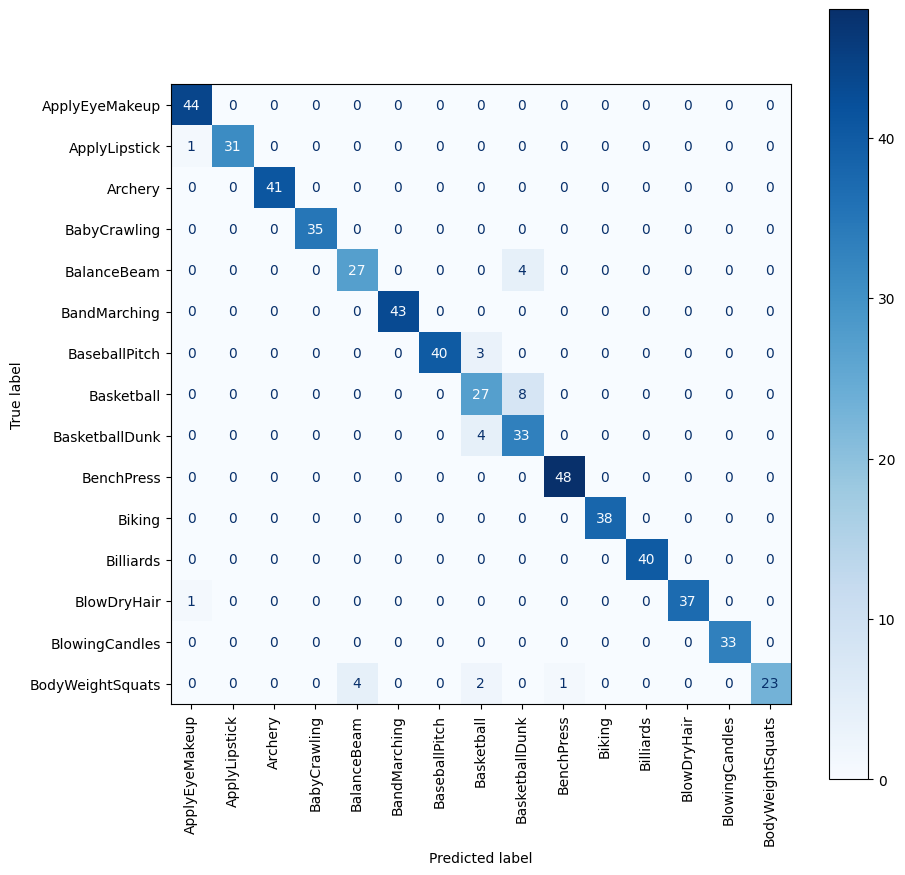

In [22]:
# 1. Calculate Top-1 Accuracy
top1_acc = accuracy_score(test_true_labels, test_predicted_labels)
print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")

# 2. Generate and Display Confusion Matrix
cm = confusion_matrix(test_true_labels, test_predicted_labels, labels=np.arange(len(CLASSES)))
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.show()

In [23]:
from sklearn.metrics import classification_report

# Create a list of the class names as strings for the report labels
class_names = [CLASSES[i] for i in sorted(list(set(test_true_labels)))]

# Generate and print the report
report = classification_report(test_true_labels, test_predicted_labels, target_names=class_names)

print(report)

                  precision    recall  f1-score   support

  ApplyEyeMakeup       0.96      1.00      0.98        44
   ApplyLipstick       1.00      0.97      0.98        32
         Archery       1.00      1.00      1.00        41
    BabyCrawling       1.00      1.00      1.00        35
     BalanceBeam       0.87      0.87      0.87        31
    BandMarching       1.00      1.00      1.00        43
   BaseballPitch       1.00      0.93      0.96        43
      Basketball       0.75      0.77      0.76        35
  BasketballDunk       0.73      0.89      0.80        37
      BenchPress       0.98      1.00      0.99        48
          Biking       1.00      1.00      1.00        38
       Billiards       1.00      1.00      1.00        40
     BlowDryHair       1.00      0.97      0.99        38
  BlowingCandles       1.00      1.00      1.00        33
BodyWeightSquats       1.00      0.77      0.87        30

        accuracy                           0.95       568
       macro

# Fine Tuning

In [24]:
# Select the last 5 rows from your DataFrame
worst_classes_df = test_class_accuracy.tail(5)

# Get the class names from the 'Class' column and convert them to a list
CLASSES_TO_FINETUNE = worst_classes_df['Class'].tolist()

print("The 5 classes with the lowest accuracy to be fine-tuned are:")
print(CLASSES_TO_FINETUNE)

The 5 classes with the lowest accuracy to be fine-tuned are:
['BaseballPitch', 'BasketballDunk', 'BalanceBeam', 'Basketball', 'BodyWeightSquats']


In [25]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "ViT-B/32"

In [39]:
# --- Reload the original pre-trained model ---
try:
    model, preprocess = clip.load(MODEL_NAME, device=DEVICE)
    
    # --- ADD THIS LINE ---
    # Convert the entire model to float32 for numerical stability
    model.float() 
    
    print(f"Reloaded original '{MODEL_NAME}' model and set to float32.")
except Exception as e:
    print(f"Error loading model: {e}")

Reloaded original 'ViT-B/32' model and set to float32.


In [40]:
def filter_data_for_classes(video_paths, labels, all_class_names, target_classes):
    """Filters the dataset to only include videos from the target classes."""
    
    filtered_paths = []
    filtered_labels = []
    
    # Create a new mapping for the target classes (e.g., 'Basketball' -> 0)
    target_label_map = {name: i for i, name in enumerate(target_classes)}
    
    for path, label_idx in zip(video_paths, labels):
        class_name = all_class_names[label_idx]
        
        # Check if the video's class is one we want to fine-tune
        if class_name in target_classes:
            filtered_paths.append(path)
            # Add the new, remapped label (0-4)
            filtered_labels.append(target_label_map[class_name])
            
    return filtered_paths, filtered_labels


# --- Run the filtering function ---
finetune_videos, finetune_labels = filter_data_for_classes(
    train_videos, 
    train_labels, 
    CLASSES, # Your original full list of 15 class names
    CLASSES_TO_FINETUNE
)

print(f"Filtered dataset created with {len(finetune_videos)} videos for fine-tuning.")

Filtered dataset created with 459 videos for fine-tuning.


In [41]:
def extract_clip(video_path, clip_duration_sec, num_frames_in_clip):
    """
    Extracts a clip and ensures it always returns `num_frames_in_clip` frames.
    """
    try:
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames_in_duration = int(clip_duration_sec * fps)
        
        if total_frames <= frames_in_duration:
            start_frame = 0
            clip_frame_count = total_frames
        else:
            center_frame = total_frames // 2
            start_frame = max(0, center_frame - (frames_in_duration // 2))
            clip_frame_count = frames_in_duration

        frame_indices = np.linspace(start_frame, start_frame + clip_frame_count - 1, num_frames_in_clip, dtype=int)
        
        frames = []
        for index in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, index)
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(Image.fromarray(frame_rgb))
        
        cap.release()

        # --- KEY FIX: Pad the frames list if it's too short ---
        if frames:
            while len(frames) < num_frames_in_clip:
                # Duplicate the last good frame to meet the required count
                frames.append(frames[-1])
        
        return frames

    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
        return []

In [42]:
class ActionDataset(Dataset):
    """Custom PyTorch Dataset that uses the corrected extract_clip function."""
    def __init__(self, video_paths, labels):
        self.video_paths = video_paths
        self.labels = labels

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        
        # This now calls the corrected function above
        frames = extract_clip(video_path, CLIP_DURATION_SEC, NUM_FRAMES_IN_CLIP)
        
        if frames:
            preprocessed_frames = torch.stack([preprocess(frame) for frame in frames])
        else:
            print(f"Warning: Could not extract frames for {video_path}. Returning a dummy tensor.")
            preprocessed_frames = torch.zeros((NUM_FRAMES_IN_CLIP, 3, 224, 224))
            
        return preprocessed_frames, label

In [43]:
# Create the dataset and loader
finetune_dataset = ActionDataset(finetune_videos, finetune_labels)
finetune_loader = DataLoader(finetune_dataset, batch_size=8, shuffle=True)

print(f"DataLoader created for the {len(CLASSES_TO_FINETUNE)} target classes.")

DataLoader created for the 5 target classes.


In [44]:
# Setup optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
loss_fn = torch.nn.CrossEntropyLoss()

def fine_tune_model(model, dataloader, optimizer, loss_fn, class_names_for_tuning, num_epochs=3):
    """
    Runs the fine-tuning loop with an epsilon value for numerical stability.
    """
    
    with torch.no_grad():
        text_prompts = [f"a photo of a person {c}" for c in class_names_for_tuning]
        text_inputs = torch.cat([clip.tokenize(prompt) for prompt in text_prompts]).to(DEVICE)
        text_features = model.encode_text(text_inputs).float()
        
        # --- FIX: Added epsilon for numerical stability ---
        text_features = text_features / (text_features.norm(dim=-1, keepdim=True) + 1e-8)
        
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # --- Forward Pass ---
            batch_size, num_frames, C, H, W = images.shape
            images = images.view(-1, C, H, W)
            image_features = model.encode_image(images).float()
            image_features = image_features.view(batch_size, num_frames, -1).mean(dim=1)

            # --- FIX: Added epsilon for numerical stability ---
            image_features = image_features / (image_features.norm(dim=-1, keepdim=True) + 1e-8)
            
            logit_scale = model.logit_scale.exp()
            logits = logit_scale * image_features @ text_features.T

            # --- Backward/Optimizer Pass ---
            loss = loss_fn(logits, labels)
            
            # Check if loss is NaN before backward pass
            if torch.isnan(loss):
                print("Warning: Loss is NaN, skipping update step.")
                continue

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
            
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

    print("Fine-tuning complete.")
    return model

In [45]:
# Run the fine-tuning process on only the 5 worst-performing classes
fine_tuned_model = fine_tune_model(
    model, 
    finetune_loader, 
    optimizer, 
    loss_fn,
    class_names_for_tuning=CLASSES_TO_FINETUNE, # Pass the list of 5 classes
    num_epochs=2
)

Epoch 1/2: 100%|██████████| 58/58 [28:03<00:00, 29.02s/it]


Epoch 1 completed. Average Loss: 0.0733


Epoch 2/2: 100%|██████████| 58/58 [27:27<00:00, 28.40s/it]

Epoch 2 completed. Average Loss: 0.0021
Fine-tuning complete.


In [46]:
SAVE_PATH = "finetuned_clip_model.pth"

torch.save(fine_tuned_model.state_dict(), SAVE_PATH)

print(f"Fine-tuned model saved to: {SAVE_PATH}")

Fine-tuned model saved to: finetuned_clip_model.pth


In [ ]:
SAVE_PATH = "finetuned_clip_model.pt"

torch.save(fine_tuned_model.state_dict(), SAVE_PATH)

print(f"Fine-tuned model saved to: {SAVE_PATH}")

Fine-tuned model saved to: finetuned_clip_model.pt


In [ ]:
def fine_tune_perform_zero_shot_classification(model, video_paths, true_labels, class_names, split_name, save_frames=False):
    """
    Runs classification. Frame saving is now optional.
    """
    model.eval()
    text_prompts = [f"a photo of a person {c}" for c in class_names]
    text_inputs = torch.cat([clip.tokenize(prompt) for prompt in text_prompts]).to(DEVICE)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    predictions, ground_truth = [], []
    
    for i, video_path in enumerate(tqdm(video_paths, desc=f"Processing {split_name} Set")):
        video_path = video_path.replace("\\", "/")
        
        if save_frames:
            class_name = class_names[true_labels[i]]
            video_filename = os.path.splitext(os.path.basename(video_path))[0]
            save_directory = os.path.join(FRAME_OUTPUT_PATH, split_name, class_name, video_filename)
            frames = extract_clip(video_path, CLIP_DURATION_SEC, NUM_FRAMES_IN_CLIP, save_dir=save_directory)
        else:
            frames = extract_clip(video_path, CLIP_DURATION_SEC, NUM_FRAMES_IN_CLIP)
        
        if not frames: continue
            
        image_inputs = torch.stack([preprocess(frame) for frame in frames]).to(DEVICE)
        
        with torch.no_grad():
            image_features = model.encode_image(image_inputs)
            video_feature = image_features.mean(dim=0)
            video_feature /= video_feature.norm(dim=-1, keepdim=True)
            
        logit_scale = model.logit_scale.exp()
        similarity = (logit_scale * video_feature @ text_features.T).softmax(dim=-1)
        _, top_pred_idx = similarity.topk(1)
        
        predictions.append(top_pred_idx.item())
        ground_truth.append(true_labels[i])
        
    return predictions, ground_truth

In [ ]:
finetuned_predicted_labels, finetuned_true_labels = fine_tune_perform_zero_shot_classification(
    fine_tuned_model,
    test_videos,
    test_labels,
    CLASSES_TO_FINETUNE,
    split_name='Test'
)

Processing Test Set:   7%|▋         | 42/568 [00:31<06:13,  1.41it/s]